# 11.3a: Dead Token Dispersion Analysis

**Goal:** Understand the structure of dead token dispersion after synthetic noise injection.

## Questions

1. **How far apart are the dead tokens?** (L∞ pairwise distances)
   - If max L∞ ≈ 2ε (6×10⁻⁵): tight lattice-scale cluster
   - If max L∞ >> ε: real diffusion, tokens scattered widely

2. **Did they change direction or just position?** (cosine similarities)
   - cos ≈ 1.0: still pointing same direction, just jiggled
   - cos < 0.99: genuinely diverged in direction

3. **Where did they go over time?** (distance from initialization vector)
   - Plot each dead token's trajectory over 10k steps

## Parameters

In [31]:
# Data from 11.2b
EMBEDDING_PATH = "../data/embeddings_128vocab_synthetic_jiggling/embedding_evolution.safetensors"

# Corpus to identify dead tokens
CORPUS_PATH = "../data/training_corpus.txt"
VOCAB_SIZE = 128

# Expected noise scale
EPSILON = 3e-5

# Plotting
COLORMAP = 'inferno'
DPI = 100

## Imports

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Load Embedding History

In [33]:
print(f"Loading embedding history from {EMBEDDING_PATH}...\n")

data = load_file(EMBEDDING_PATH)
embedding_history = data['embedding_history']  # [steps, vocab, dim]

num_steps, vocab_size, hidden_dim = embedding_history.shape

print(f"✓ Loaded embedding history")
print(f"  Steps: {num_steps:,}")
print(f"  Vocabulary: {vocab_size}")
print(f"  Hidden dim: {hidden_dim}")

Loading embedding history from ../data/embeddings_128vocab_synthetic_jiggling/embedding_evolution.safetensors...

✓ Loaded embedding history
  Steps: 10,001
  Vocabulary: 128
  Hidden dim: 64


## Identify Dead Tokens

In [34]:
print(f"\nIdentifying dead tokens...\n")

# Load corpus and find which tokens appear
with open(CORPUS_PATH, 'r', encoding='ascii') as f:
    corpus_text = f.read()

corpus_bytes = [b for b in corpus_text.encode('ascii') if b < VOCAB_SIZE]
alive_tokens = set(corpus_bytes)
dead_tokens = sorted([t for t in range(VOCAB_SIZE) if t not in alive_tokens])

print(f"✓ Dead tokens identified")
print(f"  Alive: {len(alive_tokens)}")
print(f"  Dead: {len(dead_tokens)}")
print(f"\nDead token IDs: {dead_tokens[:10]}... (showing first 10)")


Identifying dead tokens...

✓ Dead tokens identified
  Alive: 77
  Dead: 51

Dead token IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]... (showing first 10)


## Extract Initial and Final Dead Token Embeddings

In [35]:
# Initial embeddings (step 0)
initial_embeddings = embedding_history[0]
initial_dead = initial_embeddings[dead_tokens]  # [n_dead, dim]

# Final embeddings (last step)
final_embeddings = embedding_history[-1]
final_dead = final_embeddings[dead_tokens]  # [n_dead, dim]

# Convert to float32 for precise computation
initial_dead = initial_dead.to(torch.float32)
final_dead = final_dead.to(torch.float32)

print(f"\n✓ Extracted dead token embeddings")
print(f"  Initial shape: {initial_dead.shape}")
print(f"  Final shape: {final_dead.shape}")


✓ Extracted dead token embeddings
  Initial shape: torch.Size([51, 64])
  Final shape: torch.Size([51, 64])


## 1. Pairwise L∞ (Chebyshev) Distances

In [36]:
print(f"\nComputing pairwise L∞ distances...\n")

# Compute pairwise differences
v1 = final_dead.unsqueeze(1)  # [n, 1, d]
v2 = final_dead.unsqueeze(0)  # [1, n, d]
diffs = v1 - v2  # [n, n, d]

# L∞ distance = max absolute component difference
l_inf_distances = torch.abs(diffs).max(dim=2)[0]  # [n, n]

# Mask out diagonal (self-distances)
n_dead = len(dead_tokens)
mask = ~torch.eye(n_dead, dtype=torch.bool)
l_inf_nonzero = l_inf_distances[mask]

print(f"L∞ distances between dead tokens:")
print(f"  Min: {l_inf_nonzero.min().item():.6e}")
print(f"  Max: {l_inf_nonzero.max().item():.6e}")
print(f"  Mean: {l_inf_nonzero.mean().item():.6e}")
print(f"  Median: {l_inf_nonzero.median().item():.6e}")
print(f"\nFor reference:")
print(f"  ε (noise scale): {EPSILON:.2e}")
print(f"  2ε (lattice scale): {2*EPSILON:.2e}")
print(f"  Max L∞ / ε: {l_inf_nonzero.max().item() / EPSILON:.1f}×")


Computing pairwise L∞ distances...

L∞ distances between dead tokens:
  Min: 0.000000e+00
  Max: 4.882812e-04
  Mean: 2.374387e-04
  Median: 0.000000e+00

For reference:
  ε (noise scale): 3.00e-05
  2ε (lattice scale): 6.00e-05
  Max L∞ / ε: 16.3×


## 2. Pairwise Cosine Similarities

In [37]:
print(f"\nComputing pairwise cosine similarities...\n")

# Normalize vectors
final_dead_normed = final_dead / final_dead.norm(dim=1, keepdim=True)

# Cosine similarity matrix
cos_sim = torch.matmul(final_dead_normed, final_dead_normed.T)  # [n, n]

# Mask out diagonal
cos_sim_nondiag = cos_sim[mask]

print(f"Cosine similarities between dead tokens:")
print(f"  Min: {cos_sim_nondiag.min().item():.6f}")
print(f"  Max: {cos_sim_nondiag.max().item():.6f}")
print(f"  Mean: {cos_sim_nondiag.mean().item():.6f}")
print(f"  Median: {cos_sim_nondiag.median().item():.6f}")
print(f"\nInterpretation:")
if cos_sim_nondiag.min().item() > 0.99:
    print(f"  → Vectors still nearly parallel (minimal directional divergence)")
elif cos_sim_nondiag.min().item() > 0.95:
    print(f"  → Some directional divergence, but mostly aligned")
else:
    print(f"  → Significant directional scatter")


Computing pairwise cosine similarities...

Cosine similarities between dead tokens:
  Min: 1.000000
  Max: 1.000000
  Mean: 1.000000
  Median: 1.000000

Interpretation:
  → Vectors still nearly parallel (minimal directional divergence)


## 3. Trajectory: Distance from Initialization Vector

In [38]:
print(f"\nComputing trajectories...\n")

# Get initialization vector (all tokens start here)
init_vector = initial_embeddings[0].to(torch.float32)  # Any token works, they're all the same

# Compute L2 distance from init vector for each dead token at each step
distances = torch.zeros(num_steps, n_dead)

for step in range(num_steps):
    step_embeddings = embedding_history[step][dead_tokens].to(torch.float32)
    distances[step] = torch.norm(step_embeddings - init_vector, dim=1)

print(f"✓ Computed {num_steps:,} distance measurements for {n_dead} dead tokens")


Computing trajectories...

✓ Computed 10,001 distance measurements for 51 dead tokens


## Plot: Dead Token Trajectories

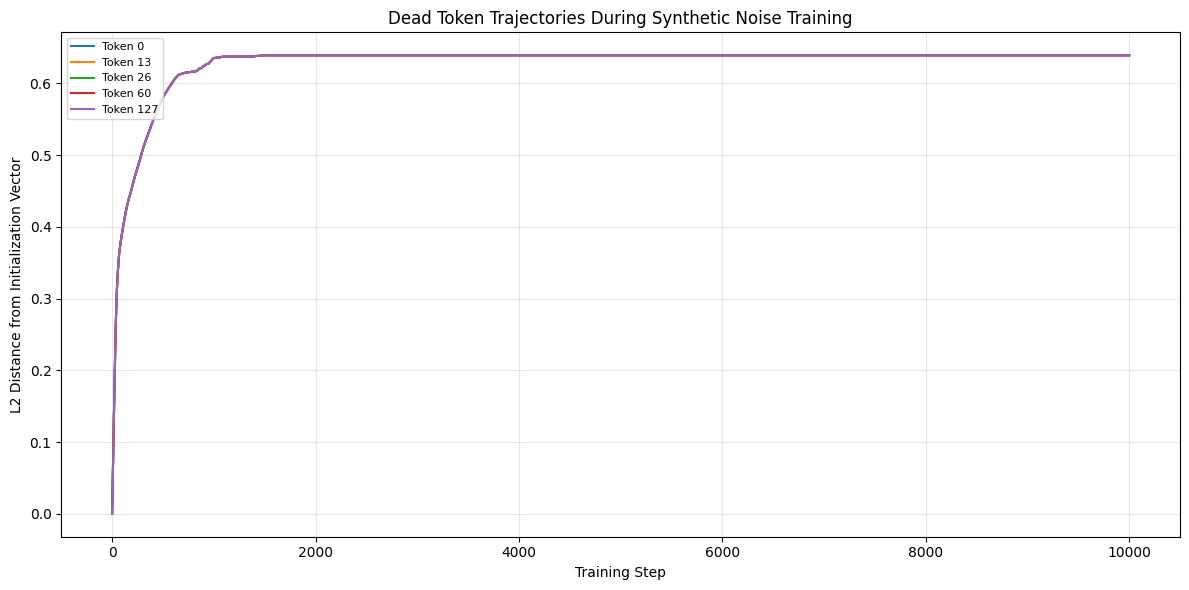


Final distances from initialization:
  Min: 0.638984
  Max: 0.639049
  Mean: 0.639023
  Std: 0.000032


In [39]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

steps = np.arange(num_steps)

# Plot all dead token trajectories
for i in range(n_dead):
    ax.plot(steps, distances[:, i].numpy(), alpha=0.3, linewidth=0.5, color='gray')

# Highlight a few for visibility
for i in [0, n_dead//4, n_dead//2, 3*n_dead//4, -1]:
    ax.plot(steps, distances[:, i].numpy(), linewidth=1.5, label=f"Token {dead_tokens[i]}")

ax.set_xlabel("Training Step")
ax.set_ylabel("L2 Distance from Initialization Vector")
ax.set_title("Dead Token Trajectories During Synthetic Noise Training")
ax.legend(loc='upper left', fontsize=8)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal distances from initialization:")
print(f"  Min: {distances[-1].min().item():.6f}")
print(f"  Max: {distances[-1].max().item():.6f}")
print(f"  Mean: {distances[-1].mean().item():.6f}")
print(f"  Std: {distances[-1].std().item():.6f}")

## Summary

In [40]:
print(f"\n{'='*80}")
print(f"DEAD TOKEN DISPERSION SUMMARY")
print(f"{'='*80}")
print(f"Dead tokens analyzed: {n_dead}")
print(f"Training steps: {num_steps - 1:,}")
print(f"Synthetic noise scale (ε): {EPSILON:.2e}")
print(f"\nSpatial dispersion (L∞):")
print(f"  Max pairwise L∞: {l_inf_nonzero.max().item():.6e}")
print(f"  Ratio to ε: {l_inf_nonzero.max().item() / EPSILON:.1f}×")
print(f"\nDirectional coherence (cosine similarity):")
print(f"  Min cosine similarity: {cos_sim_nondiag.min().item():.6f}")
print(f"\nDistance from origin:")
print(f"  Mean final distance: {distances[-1].mean().item():.6f}")
print(f"\nConclusion:")
if l_inf_nonzero.max().item() < 10 * EPSILON:
    print(f"  ✓ Dead tokens remain in tight ε-scale cluster")
    print(f"  → Noise scale is appropriate for lattice-scale jiggling")
else:
    print(f"  ✗ Dead tokens scattered widely (max L∞ = {l_inf_nonzero.max().item() / EPSILON:.0f}× ε)")
    print(f"  → Consider reducing noise scale for tighter clustering")

if cos_sim_nondiag.min().item() > 0.99:
    print(f"  ✓ Dead tokens maintained directional coherence")
else:
    print(f"  ⚠ Dead tokens diverged directionally")
print(f"{'='*80}")


DEAD TOKEN DISPERSION SUMMARY
Dead tokens analyzed: 51
Training steps: 10,000
Synthetic noise scale (ε): 3.00e-05

Spatial dispersion (L∞):
  Max pairwise L∞: 4.882812e-04
  Ratio to ε: 16.3×

Directional coherence (cosine similarity):
  Min cosine similarity: 1.000000

Distance from origin:
  Mean final distance: 0.639023

Conclusion:
  ✗ Dead tokens scattered widely (max L∞ = 16× ε)
  → Consider reducing noise scale for tighter clustering
  ✓ Dead tokens maintained directional coherence
